In [ ]:
from scapy.all import *
import matplotlib.pyplot as plt
from scapy.layers.inet import TCP, IP

In [10]:
pcap = rdpcap('Q2-part1.pcap')

In [11]:
connections = {}

# Process each packet in the PCAP
for pkt in pcap:
    if not (IP in pkt and TCP in pkt):
        continue  # Skip non-TCP/IP packets

    ip = pkt[IP]
    tcp = pkt[TCP]
    
    # Connection tuple (src_ip, dst_ip, src_port, dst_port)
    conn_tuple = (ip.src, ip.dst, tcp.sport, tcp.dport)
    reverse_tuple = (ip.dst, ip.src, tcp.dport, tcp.sport)

    # Track SYN (connection initiation)
    if tcp.flags & 0x02:  # SYN flag
        if tcp.flags & 0x10:  # ACK flag (SYN-ACK response)
            # Server responding to SYN, ignore for connection start
            continue
        else:  # Initial SYN (client -> server)
            if conn_tuple not in connections:
                connections[conn_tuple] = {
                    'start_time': pkt.time,
                    'end_time': None,
                    'state': 'open'
                }
    
    # Track FIN-ACK (graceful closure) or RST (abrupt closure)
    elif tcp.flags & 0x01 or tcp.flags & 0x04:  # FIN (0x01) or RST (0x04)
        if reverse_tuple in connections:
            if connections[reverse_tuple]['state'] == 'open':
                connections[reverse_tuple]['end_time'] = pkt.time
                connections[reverse_tuple]['state'] = 'closed'

In [12]:
for i in connections.values():
  starting = i['start_time']
  break

# Calculate durations
start_times = []
durations = []
for conn in connections.values():
    if conn['end_time']:
        duration = conn['end_time'] - conn['start_time']
    else:
        duration = 120  # Unclosed connection
    start_times.append(conn['start_time'] - starting)
    durations.append(duration)

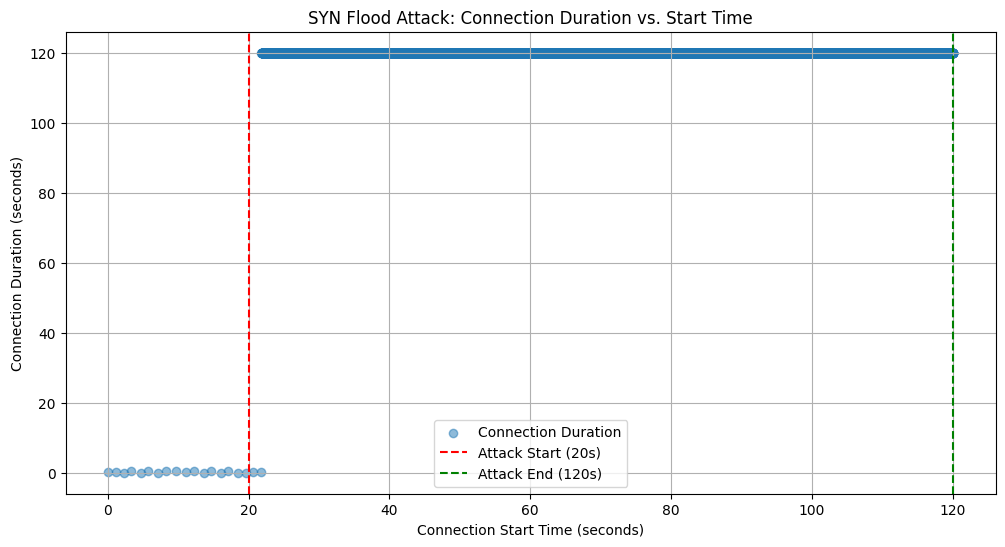

In [13]:
# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(start_times, durations, alpha=0.5, label='Connection Duration')
plt.axvline(x=20, color='red', linestyle='--', label='Attack Start (20s)')
plt.axvline(x=120, color='green', linestyle='--', label='Attack End (120s)')
plt.xlabel('Connection Start Time (seconds)')
plt.ylabel('Connection Duration (seconds)')
plt.title('SYN Flood Attack: Connection Duration vs. Start Time')
plt.legend()
plt.grid(True)
plt.show()